In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
import cv2
import math

In [2]:
def apply_hsv_adjustment(image, era):
    """Apply HSV preprocessing based on the selected era."""
    hsv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2HSV)
    
    era_hsv_values = {
        "pre_1900s": (0, 0, (20, 90)),         # Grayscale
        "1900s_1930s": (30, (10, 30), (40, 85)),  # Sepia tint
        "1940s_1960s": (0, (60, 90), (50, 95)),  # Technicolor
        "1970s_1980s": (75, (20, 50), (30, 80)), # Faded film
        "1990s_2000s": (0, (50, 80), (40, 90)),  # Early digital
        "2010s_present": (0, (80, 100), (50, 100)) # HDR
    }
    
    if era not in era_hsv_values:
        raise ValueError("Invalid era. Choose from: " + ", ".join(era_hsv_values.keys()))
    
    h_shift, s_range, v_range = era_hsv_values[era]
    
    # Adjust Hue
    hsv[:, :, 0] = (hsv[:, :, 0] + h_shift) % 180  # OpenCV uses 0-179 for Hue
    
    # Adjust Saturation
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * (s_range[1] / 100), s_range[0], s_range[1])
    
    # Adjust Value (Brightness)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * (v_range[1] / 100), v_range[0], v_range[1])
    
    return Image.fromarray(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))

# usage inside the dataset transform pipeline
class HSVTransform:
    def __init__(self, era):
        self.era = era

    def __call__(self, img):
        return apply_hsv_adjustment(img, self.era)


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")

NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    # HSVTransform('pre_1900s'),  # uncomment and adjust
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # New layer
        self.bn4 = nn.BatchNorm2d(256)  # Batch norm for new layer
        self.conv5 = nn.Conv2d(256, 3, kernel_size=5, stride=1, padding=4, dilation=2)

        self.dropout = nn.Dropout(0.3)  # Added dropout layer

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)  # Apply dropout
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)  # Apply dropout
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)  # Apply dropout
        x = nn.functional.relu(self.bn4(self.conv4(x)))  # New layer
        x = torch.sigmoid(self.conv5(x))
        return x

In [6]:
# Training Setup
model = ColorizationNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
print(model)


ColorizationNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 3, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (dropout): Dropout(p=0.3, inplace=False)
)


In [7]:
# Utility Functions
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def imshow(img):
    img = torch.clamp(img, 0, 1)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [8]:
def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):
    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")
        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [9]:
# Training Loop
EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    for i, (images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)
        outputs = model(grayscale_images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    scheduler.step()
print("Finished Training")

Epoch [1/30], Step [1/782], Loss: 0.0856
Epoch [1/30], Step [101/782], Loss: 0.0116
Epoch [1/30], Step [201/782], Loss: 0.0087
Epoch [1/30], Step [301/782], Loss: 0.0090
Epoch [1/30], Step [401/782], Loss: 0.0074
Epoch [1/30], Step [501/782], Loss: 0.0048
Epoch [1/30], Step [601/782], Loss: 0.0063
Epoch [1/30], Step [701/782], Loss: 0.0109
Epoch [2/30], Step [1/782], Loss: 0.0054
Epoch [2/30], Step [101/782], Loss: 0.0069
Epoch [2/30], Step [201/782], Loss: 0.0073
Epoch [2/30], Step [301/782], Loss: 0.0075
Epoch [2/30], Step [401/782], Loss: 0.0092
Epoch [2/30], Step [501/782], Loss: 0.0079
Epoch [2/30], Step [601/782], Loss: 0.0071
Epoch [2/30], Step [701/782], Loss: 0.0068
Epoch [3/30], Step [1/782], Loss: 0.0082
Epoch [3/30], Step [101/782], Loss: 0.0067
Epoch [3/30], Step [201/782], Loss: 0.0073
Epoch [3/30], Step [301/782], Loss: 0.0078
Epoch [3/30], Step [401/782], Loss: 0.0079
Epoch [3/30], Step [501/782], Loss: 0.0066
Epoch [3/30], Step [601/782], Loss: 0.0063
Epoch [3/30], Ste

In [13]:
torch.save(model.state_dict(), "models/task2_weights.pt")
torch.save(model,"models/task2_model.pt")

In [14]:
def colorize_image(image_path):
    original_image = Image.open(image_path) # Load original for display later
    image = original_image.convert("L")  # Grayscale conversion
    tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        colorized = model(tensor).squeeze(0).cpu().numpy().transpose(1, 2, 0)

    colorized = (colorized * 255).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

    # Original Image Display
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Grayscale Image Display
    axes[1].imshow(image, cmap="gray")
    axes[1].set_title("Grayscale Input")
    axes[1].axis('off')

    # Colorized Image Display
    axes[2].imshow(colorized)
    axes[2].set_title("Colorized Output")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

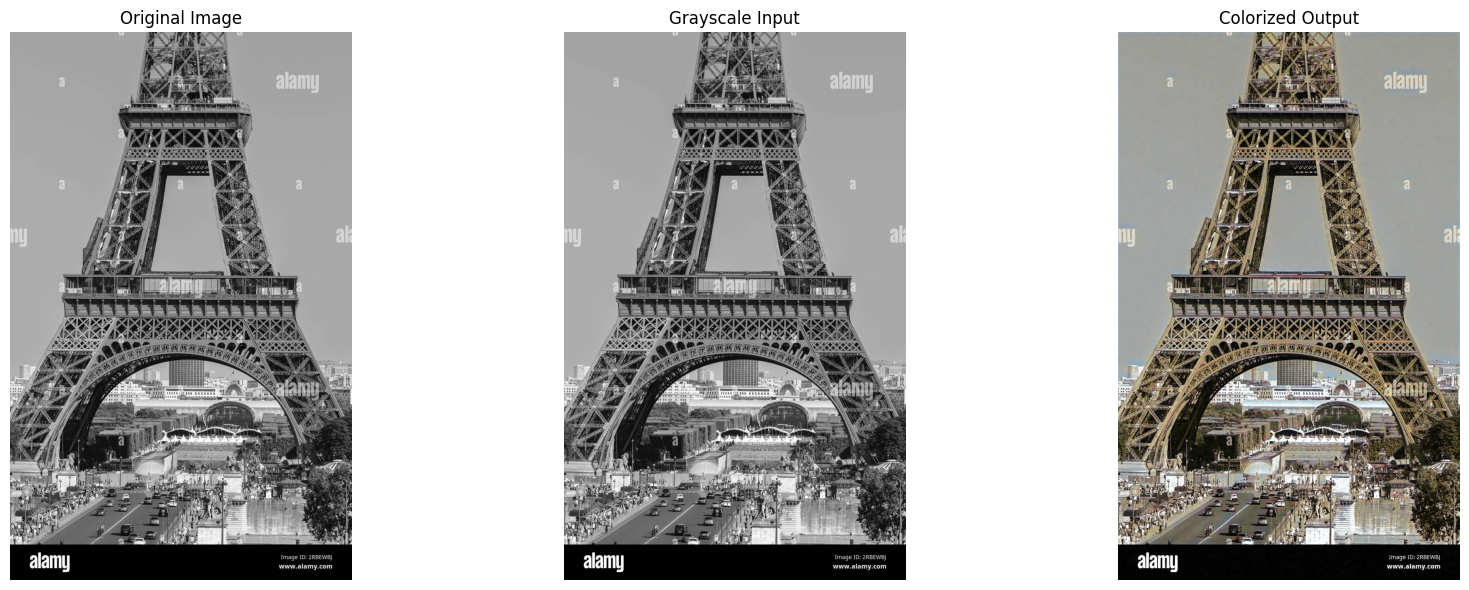

In [15]:
colorize_image(r"Images to process\eiffel2.jpg")